<a href="https://colab.research.google.com/github/finardi/IA376A/blob/master/IMBD-Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="color:orange"> Paulo Finardi </span>

<span style="color:purple"> Semana: 7 </span>
    



## <span style="color:orange"> Bibliotecas e função que torna os testes pseudo determínisticos

    



In [ ]:
# Parâmetros do exercício:
manualSeed = 0
batch_size = 50
lr = 0.001
n_epocas = 15
seq_len = 200
gloveDim = 300
tokenizerType = "spacy"
download = False

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torchtext.data import get_tokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import os
from torchtext.vocab import GloVe

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# cód. Diedre
def get_device(force_cpu=False):
    '''
    Gets pytorch current available device
    '''
    if torch.cuda.is_available() is True and not force_cpu:
        device = torch.device("cuda:0")
        print("CUDA device found: " + str(device))
        print("GPU: " + str(get_device_name(0)))
        GPU_MEMORY_GBS = torch.cuda.get_device_properties(device).total_memory / 1000000000
        print("TOTAL GPU MEMORY: {}".format(GPU_MEMORY_GBS))
    else:
        device = torch.device("cpu")
        print("CUDA device not available or forced disabled. Using CPU.")
    return device
device = get_device(force_cpu=False)
print(f'Number of CPU cores: {cpu_count()}')

CUDA device found: cuda:0
GPU: Tesla P4
TOTAL GPU MEMORY: 7.981694976
Number of CPU cores: 2


# <span style="color:orange"> Embeddings do glove

Download ou uso do já baixado no drive.

In [ ]:
!wget -nc http://nlp.stanford.edu/data/glove.6B.zip
!unzip -f glove.6B.zip -d glove_dir
gloveCache = './glove_dir'

--2020-04-23 00:13:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-23 00:13:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-23 00:13:53--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
glove_vectors = GloVe(name='6B', dim=gloveDim, cache=gloveCache)

./glove_dir/glove.6B.zip: 862MB [06:27, 2.23MB/s]                           
100%|█████████▉| 398932/400000 [00:37<00:00, 10733.89it/s]

In [ ]:
print(glove_vectors.vectors.shape)
print(
        'Primeiras 10 palavras e seus índices:',
        list(glove_vectors.stoi.items())[:10]
     )

torch.Size([400000, 300])
Primeiras 10 palavras e seus índices: [('the', 0), (',', 1), ('.', 2), ('of', 3), ('to', 4), ('and', 5), ('in', 6), ('a', 7), ('"', 8), ("'s", 9)]


In [ ]:
# cód. Gustavo Plensack

# Cuidado, as strings devem estar todas em lowercase,
# nesse caso duas palavras distintas têm o mesmo embedding,
# que provavelmente é o do token desconhecido.
print('Caixa mista:',(glove_vectors['Test'] - glove_vectors['Nothing']).sum())
print('Caixa baixa:',(glove_vectors['test'] - glove_vectors['nothing']).sum())

Caixa mista: tensor(0.)
Caixa baixa: tensor(-0.2714)


In [ ]:
glove_vectors = GloVe(name='6B', dim=gloveDim, cache=gloveCache)

# aumentando uma entrada no GloVe para garantir que ele funcione no embedding
# com o unk e pad - Obrigado pela dica Israel

pad_token_idx = len(glove_vectors.vectors)
unk_token_idx = len(glove_vectors.vectors) + 1

glove_vectors.vectors = torch.cat((glove_vectors.vectors, torch.zeros(2, gloveDim)))

vocab_size = len(glove_vectors.vectors)

glove_vectors.vectors.shape

torch.Size([400002, 300])

In [ ]:
print(f'token unk: {unk_token_idx} e token pad: {pad_token_idx}')

token unk: 400001 e token pad: 400000


In [ ]:
print(f'O tamanho do vocabulário é {vocab_size}')

O tamanho do vocabulário é 400002


## <span style="color:orange"> Instanciando o tokenizador

Implementação baseada na do colega Israel da última semana, eu não conhecia o pacote do torch text e que ele tinha o tokenizadores pré-definidos. O tokenizador a ser usado é definido na primeira célula do notebook.

In [ ]:
tokenizer = get_tokenizer(tokenizerType)

## <span style="color:orange"> Dados IMDB

Primeiro, fazemos download do dataset:

In [ ]:
!wget -q -nc http://files.fast.ai/data/aclImdb.tgz 
!tar -xzf aclImdb.tgz

100%|█████████▉| 398932/400000 [00:50<00:00, 10733.89it/s]

In [ ]:
# cód. Gustavo Plensack

def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos = load_texts('aclImdb/test/pos')
x_test_neg = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg

# Convertendo para caixa baixa
x_train = [sample.lower() for sample in x_train]
x_test = [sample.lower() for sample in x_test]

y_train = [1] * len(x_train_pos) + [0] * len(x_train_neg)
y_test = [1] * len(x_test_pos) + [0] * len(x_test_neg)


# Separando treino de validação usando o sklearn
x_train, x_valid, y_train, y_valid = train_test_split(x_train,
                                                      y_train,
                                                      test_size=0.2,
                                                      random_state=manualSeed)

20000 amostras de treino.
25000 amostras de teste.
--- 3 primeiras amostras treino: ---
1 some people have stated that as of the 11th season, south park has started a trend of leaving behind
0 i am uncertain what to make of this misshapen 2007 dramedy. attempting to be a new millennium cross-
0 you, know, i can take the blood and the sex, but that thong bikini shot pretty much did me in. someo
--- 3 últimas amostras treino: ---
1 as essential a part of british pop culture as the monty python and james bond, doctor who was a mass
1 with the death of her infirmed husband, may, an older woman faces a future in an urban world that vi
1 anna (charlotte burke) develops a strange fever that causes her to pass out and drift off into a wor
--- 3 primeiras amostras validação: ---
0 vampires vs. zombies starts with the breaking news that the unidentified disease that is spreading a
1 i was all ready to pan this episode, seeing that this 'master' really doesn't have any horror films 
0 sean, you k

In [ ]:
#Testando separação em treino e validação
len(x_train),len(y_train),len(x_valid),len(y_valid)

(20000, 20000, 5000, 5000)

## <span style="color:orange"> Tokenizando o texto e obtendo a sequência de indexes do glove

In [ ]:
# cód. Gustavo Plensack

def tokenize_and_pad(texts, seq_len=seq_len, pad_token_idx=pad_token_idx,
                    unk_token_idx=unk_token_idx,tokenizer=tokenizer):
  '''
  Tokeniza e retorna as sequências de ids dos tokens e com tamanho limitado
  por seq_len. Abordagem inspirada na do colega Israel
  '''
  processed_texts = []
  masks = []
  for text in texts:
    tokens = tokenizer(str(text))
    end = min(len(tokens), seq_len)
    toks = tokens[:end]

    token_ids, mask = [], []
    for t in toks:
      if t in glove_vectors.stoi.keys():
        tid = glove_vectors.stoi[t]
        m = 1
      else:
        tid = unk_token_idx
        m = 0
      token_ids.append(tid)
      mask.append(m)  
      
    if len(token_ids) < seq_len:
      missing = seq_len - len(token_ids)
      mask = mask + [0] * missing
      token_ids = token_ids + [pad_token_idx] * missing

    processed_texts.append(token_ids)
    masks.append(mask)

  return processed_texts, masks

In [ ]:
X_valid,masks_valid = tokenize_and_pad(x_valid)
X_train,masks_train = tokenize_and_pad(x_train)
X_test,masks_test = tokenize_and_pad(x_test)

##  <span style="color:orange"> Classe dataset

In [ ]:
# cód. Gustavo Plensack

class SentimentDataset(Dataset):
  '''
  Implementa o dataset de forma bastante simples. Já espera os dados
  pré-processados e não executa nenhuma alteração neles, apenas os converte
  para torch.
  '''
  def __init__(self, X,mask,y,padding_token=len(glove_vectors.vectors)):
    super(SentimentDataset, self).__init__()

    self.y = torch.LongTensor(y)
    self.X = torch.LongTensor(X)
    self.mask = torch.LongTensor(mask)
    
  def __len__(self):
    return self.y.shape[0]
  
  def __getitem__(self, index):
    return self.X[index],self.mask[index], self.y[index]

In [ ]:
# teste classe dataset
x,mask,y = SentimentDataset(X_train,masks_train,y_train)[:]
x.shape,mask.shape,y.shape

(torch.Size([20000, 200]), torch.Size([20000, 200]), torch.Size([20000]))

## <span style="color:orange"> Dataloader

In [ ]:
trainDS = SentimentDataset(X_train,masks_train,y_train)
valDS   = SentimentDataset(X_valid ,masks_valid,y_valid)
testDS  = SentimentDataset(X_test ,masks_test,y_test)

# Dataloader
BATCH_SZ = 128

dataloaders = {
    'train': DataLoader(trainDS,batch_size=BATCH_SZ, shuffle=True, num_workers=0, pin_memory=True),
    'val':   DataLoader(valDS,  batch_size=BATCH_SZ, shuffle=False,num_workers=0, pin_memory=True),
    'test':  DataLoader(testDS, batch_size=BATCH_SZ, shuffle=False,num_workers=0, pin_memory=True)
}
dataloaders_sizes = {
    x: len(dataloaders[x]) for x in dataloaders.keys()
}
dataloaders_sizes

{'test': 196, 'train': 157, 'val': 40}

In [ ]:
# Testando a classe dataloader junto com o dataset
x, mask,y = next(iter(dataloaders['train']))
x.shape,mask.shape,y.shape

(torch.Size([128, 200]), torch.Size([128, 200]), torch.Size([128]))

# <span style="color:orange"> Modelo

In [ ]:
vocab_size, emb_dim = glove_vectors.vectors.shape
vocab_size, emb_dim

(400002, 300)

In [ ]:
class MultiHeadAttention(nn.Module):

  def __init__(self, embed_dim, nheads):
    assert embed_dim % nheads == 0
    super().__init__()
    self.embed_dim = embed_dim
    self.nheads = nheads

    self.query = nn.Linear(embed_dim, embed_dim, bias=False)
    self.key = nn.Linear(embed_dim, embed_dim, bias=False)
    self.value = nn.Linear(embed_dim, embed_dim, bias=False)
    self.context = nn.Linear(embed_dim, embed_dim)
    self.drop = nn.Dropout(0.1)

  def split_heads(self, x):
    N, L, D = x.shape
    return x.view(N, L, self.nheads, D//self.nheads).transpose(1,2) # (N, H, L, D/H)

  def merge_heads(self, x):
    N, H, L, D = x.shape
    return x.transpose(1,2).contiguous().view(N, L, -1)

  def forward(self, key, query, value, mask=None):
    key = self.split_heads(self.key(key))
    query = self.split_heads(self.query(query))
    value = self.split_heads(self.value(value))

    d = key.shape[-1] # embedding dimensions
    scores = query @ key.transpose(-1, -2) # (batch_size, nheads, seq_len, seq_len)
    if mask is not None:
        mask = mask[:, None, None, :] # (batch_size, nheads, seq_len, seq_len)
        mask = (1. - mask) * (-1e10) 
        scores = scores + mask
    probs = torch.softmax(scores / math.sqrt(d), dim=-1)
    probs = self.drop(probs)
    E = probs @ value # (batch_size, nheads, seq_len, embed_dim/nheads)
    E = self.merge_heads(E) # (batch_size, seq_len, embed_dim)
    E = self.context(E)
    return E    

class Transformer(nn.Module):

  def __init__(self, embed_dim, nheads=1, max_seq_length=512):
    super().__init__()

    self.positional_embedding = nn.Embedding(max_seq_length, embed_dim)
    self.multi_head = MultiHeadAttention(embed_dim, nheads)

    self.feedforward = nn.Sequential(
        nn.Linear(embed_dim, embed_dim),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(embed_dim, embed_dim)
    )

    self.ln1 = nn.LayerNorm(embed_dim)
    self.ln2 = nn.LayerNorm(embed_dim)

  def positional_emb(self, x):
    _, L, _ = x.shape
    ids = torch.arange(end=L, device=x.device)
    return self.positional_embedding(ids)

  def forward(self, x, mask=None):
    # sum the positional embedding
    x = self.positional_emb(x) + x # (batch, seq, emb)

    # passes to multi head attention
    mha = self.multi_head(x, x, x, mask)
    mha = self.ln1(mha + x)

    # computes the ff
    ff = self.feedforward(mha)
    ff = self.ln2(ff + mha)
    return ff

In [ ]:
# cód. Israel

class Model(nn.Module):

  def __init__(self, vocab_size, emb_dim, out_features=2, nheads=1):
    super().__init__()
    self.vocab_size = vocab_size
    self.emb_dim = emb_dim

    self.emb = nn.Embedding.from_pretrained(glove_vectors.vectors, freeze=True)

    self.attention = Transformer(emb_dim, nheads=nheads)
    self.classifier = nn.Linear(emb_dim, out_features)

  def grad_embs(self, grad=False):
    for params in self.emb.parameters():
        params.requires_grad = grad

  def forward(self, x, mask=None):
    embs = self.emb(x) # (batch_size, seq_len, emb_dim)
    attn = self.attention(embs, mask) # (batch_size, seq_len, emb_dim)
    if mask is not None:
      attn = (attn.permute(2, 0, 1) * mask).permute(1,2,0).contiguous() # this will ignore the padding on the mean
      attn = (attn.sum(1).transpose(-2, -1) / mask.sum(1)).transpose(-2, -1) # (batch_size, out_features)
    else:
      attn = attn.mean(1)
    out = self.classifier(attn) # (batch_size, out_features)
    return out

In [ ]:
model = Model(vocab_size, emb_dim, nheads=6)
model.to(device)

with torch.no_grad():
  out = model(x.to(device), mask=mask.to(device))
out.shape

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('\n','#' * 46,f'\n # The model has {count_parameters(model):,}' \
       ' trainable parameters #\n', '#' * 46,'\n' )  


 ############################################## 
 # The model has 696,302 trainable parameters #
 ############################################## 



# <span style="color:orange"> Função Treino/Validação

In [ ]:
from sklearn.metrics import accuracy_score

def train(model, device, train_loader, loss_fn, optimizer):
  model.train()
  loss_train = []
  for data, mask, target in train_loader:
    data, mask, target = data.to(device), mask.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data, mask)
    loss = loss_fn(output, target)
    loss_train.append(loss.item())
  
    loss.backward()
    optimizer.step()
  
  ave_train_loss = sum(loss_train) / len(loss_train)
  return ave_train_loss

def test(model, device, valid_loader, loss_fn):
  model.eval()
  logits, trues, loss_test = [],[],[]
  with torch.no_grad():
    for data, mask, target in valid_loader:
      data, mask, target = data.to(device), mask.to(device), target.to(device)
      output = model(data, mask)
      loss = loss_fn(output, target)
      loss_test.append(loss.item())
      
      logits.extend(output.to('cpu').numpy().tolist())
      trues.extend(target.to('cpu').numpy().tolist())
      prob = F.softmax(torch.tensor(logits), dim=1).numpy().copy()
      probs = prob[:,1]
  
    ave_test_loss = sum(loss_test) / len(loss_test)
  return ave_test_loss, accuracy_score(trues, probs.round()) 

#  <span style="color:orange">  Treino em um único Batch - check de convergência





In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

deterministic() 

model = Model(vocab_size, emb_dim, nheads=5).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters())
N_EPOCHS  = 1000

#-------------------------- pega um único batch
data, mask, target = next(iter(dataloaders['train']))
loss_train = []

# start time record
start.record()

for step in range(1, N_EPOCHS+1):
    model.train()
    data, mask, target = data.to(device), mask.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss   = criterion(output, target)
    loss_train.append(loss.item())
    loss.backward()
    optimizer.step()
    ave_train_loss = sum(loss_train) / len(loss_train)
    
    if step ==1:
        print(f'[Epoch [{step}/{N_EPOCHS}] |', end=' ')
        print(f'Train Loss: {ave_train_loss:.3f}')
    if step % 50 == 0:
        print(f'[Epoch [{step}/{N_EPOCHS}] |', end=' ')
        print(f'Train Loss: {ave_train_loss:.3f}')

print(f'\nEnd of training.')

# end time record
end.record()
torch.cuda.synchronize()

print(f'Tempo: {start.elapsed_time(end)/1000 :.3} seg.')

Deterministic experiment, seed: 0
[Epoch [1/1000] | Train Loss: 0.701
[Epoch [50/1000] | Train Loss: 0.459
[Epoch [100/1000] | Train Loss: 0.231
[Epoch [150/1000] | Train Loss: 0.154
[Epoch [200/1000] | Train Loss: 0.116
[Epoch [250/1000] | Train Loss: 0.093
[Epoch [300/1000] | Train Loss: 0.077
[Epoch [350/1000] | Train Loss: 0.066
[Epoch [400/1000] | Train Loss: 0.058
[Epoch [450/1000] | Train Loss: 0.051
[Epoch [500/1000] | Train Loss: 0.046
[Epoch [550/1000] | Train Loss: 0.042
[Epoch [600/1000] | Train Loss: 0.039
[Epoch [650/1000] | Train Loss: 0.036
[Epoch [700/1000] | Train Loss: 0.033
[Epoch [750/1000] | Train Loss: 0.031
[Epoch [800/1000] | Train Loss: 0.029
[Epoch [850/1000] | Train Loss: 0.027
[Epoch [900/1000] | Train Loss: 0.026
[Epoch [950/1000] | Train Loss: 0.024
[Epoch [1000/1000] | Train Loss: 0.023

End of training.
Tempo: 67.8 seg.


# <span style="color:orange"> Medindo o tempo com torch.cuda.Event

In [ ]:
# Tempos gasto no treino
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
_ = train(model, device, dataloaders['train'], criterion, optimizer)
end.record()
torch.cuda.synchronize()    

print(f'Tempo no treino em 20k exemplos: {start.elapsed_time(end)/1000 :.3f} seg.')

# Tempos gasto no teste
start.record()
_, _ =  test(model, device, dataloaders['val'], criterion)
end.record()
torch.cuda.synchronize()    

print(f'Tempo no teste em 5k exemplos: {start.elapsed_time(end)/1000 :.3f} seg.')

Tempo no treino em 20k exemplos: 11.117 seg.
Tempo no teste em 5k exemplos: 1.060 seg.


### <span style="color:orange">Calculando a memória

In [ ]:
!pip install -q memory_profiler
%load_ext memory_profiler

In [ ]:
%memit test(model, device, dataloaders['val'], criterion)

peak memory: 5987.88 MiB, increment: 0.12 MiB


# <span style="color:orange"> Treinamento

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

deterministic() 
#--------------- configuração de treino
N_EPOCHS  = 30
model = Model(vocab_size, emb_dim, nheads=5).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters())
epoch, best_acc = 0,0

#-------------------- looping de treino
start.record()
for step in range(1, N_EPOCHS+1):
    loss_t      = train(model, device, dataloaders['train'], criterion, optimizer)
    loss_v, acc =  test(model, device, dataloaders['val'],   criterion)
    if acc >= best_acc:
        best_acc = acc
        epoch    = step
        torch.save(model.state_dict(), os.path.join('', 'epoch_-{}.pth'.format(epoch)))
        print(f'[Epoch [{step}/{N_EPOCHS}] |', end=' ')
        print(f'Train Loss: {loss_t:.3f} -- Valid Loss: {loss_v:.3f} --',end=' ')
        print(f'Acc: {acc:.3f}')
end.record()
torch.cuda.synchronize()    

print(f'\nEnd of training. Best Acc: -->[{best_acc:.4f}]<--, at epoch: {epoch}\n')
print(f'Tempo: {start.elapsed_time(end)/1000/60 :.3f} min.')

Deterministic experiment, seed: 0
[Epoch [1/30] | Train Loss: 0.533 -- Valid Loss: 0.542 -- Acc: 0.730
[Epoch [2/30] | Train Loss: 0.424 -- Valid Loss: 0.458 -- Acc: 0.787
[Epoch [3/30] | Train Loss: 0.400 -- Valid Loss: 0.409 -- Acc: 0.813
[Epoch [4/30] | Train Loss: 0.380 -- Valid Loss: 0.410 -- Acc: 0.817
[Epoch [5/30] | Train Loss: 0.367 -- Valid Loss: 0.406 -- Acc: 0.821

End of training. Best Acc: -->[0.8210]<--, at epoch: 5

Tempo: 6.270 min.


#  <span style="color:orange"> Validação no conj. de teste


In [ ]:
def logits_and_trues(model, dataloader, device=device):
    model.eval()
    logits, trues = [],[]
    for x, mask, y in dataloader:
        with torch.no_grad():
            y_pred = model(x.to(device), mask.to(device))
            logits.extend(y_pred.to('cpu').numpy().tolist())
            trues.extend(y.to('cpu').numpy().tolist())
    return torch.tensor(logits), np.array(trues)

In [ ]:
model = Model(vocab_size, emb_dim, nheads=5).to(device)
string = '/content/epoch_-5.pth'
model.load_state_dict(torch.load(string, map_location=device))

logits, trues = logits_and_trues(model, dataloaders['test'], device=device)
prob  = F.softmax(logits, dim=1).detach().numpy()
probs = prob[:,1]
y     = pd.Series(trues)
y_pred= pd.Series(probs)
print(f'Acc = {accuracy_score(y, y_pred.round())}')

Acc = 0.8194


<Figure size 432x288 with 0 Axes>

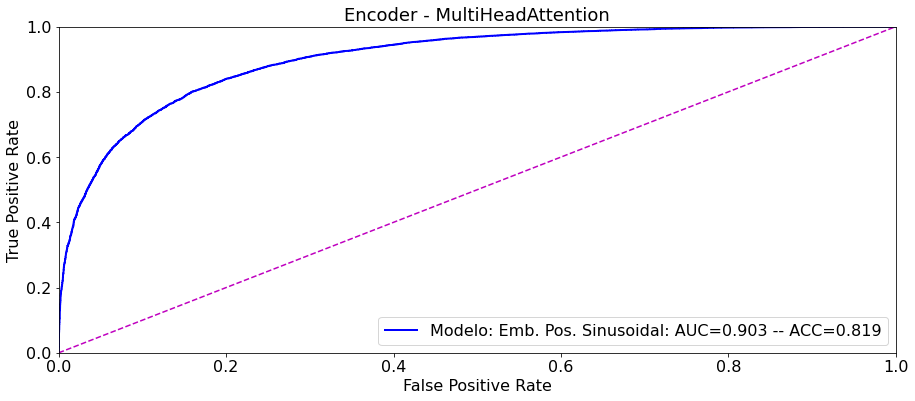

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(y, y_pred):
    fpr, tpr,_ = roc_curve(y, y_pred)
    roc_auc    = auc(fpr, tpr)
    acc        = accuracy_score(y, y_pred.round())
    
    # plot
    fig = plt.figure()
    plt.figure(figsize=(15, 6))
    plt.plot(fpr,tpr,'b',lw=2,label='%s AUC=%0.3f -- ACC=%0.3f'%('Modelo: Emb. Pos. Sinusoidal:',roc_auc,acc))
    plt.plot([0, 1], [0, 1], 'm--')
    
    # decoração
    plt.xlim([0.0, 1.0])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim([0.0, 1.0])
    plt.title('Encoder - MultiHeadAttention', size=18)
    plt.xlabel('False Positive Rate', size=16)
    plt.ylabel('True Positive Rate', size=16)
    plt.legend(loc=0, fontsize=16)
    plt.show()

plot_roc_curve(y, y_pred)

# <span style="color:purple">Fim do notebook



